# Keyword Spotting: data analysis and preprocessing inspection

## Get scripts from GitHub and install wget
Only required when running on Colab. 

In [6]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=f6d7fc469e5ba1604882fb64595c8f0c48038f5fb2516bfafedc1cc81cae52aa
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [7]:
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/preprocessing_utils.py

--2023-01-23 08:53:36--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2253 (2.2K) [text/plain]
Saving to: ‘plot_utils.py’

plot_utils.py       100%[===================>]   2.20K  --.-KB/s    in 0s      

2023-01-23 08:53:36 (47.1 MB/s) - ‘plot_utils.py’ saved [2253/2253]

--2023-01-23 08:53:37--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/preprocessing_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94

## Import

In [8]:
import os
import pathlib
import requests
import wget
import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython.display import display, Audio, Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.io import wavfile

plt.rcParams['font.size'] = '12'
# %matplotlib inline

In [9]:
print("GPU Available:", tf.test.is_gpu_available())
print("Version:", tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
Version: 2.9.2


To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [10]:
# uncomment to install python_speech_features
! pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import plot_utils, preprocessing_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=e605968d17ee6148e7cba671f4f29405888050c8ee9eac5d6fc8fe5bc4e3e6cf
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features


To perform Discrete Wavelet Transform on audio signals we use the Python library [PyWavelets](https://github.com/PyWavelets/pywt).

In [11]:
# uncomment to install PyWavelets
! pip install PyWavelets

from pywt import dwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1 - Data loading and preprocessing
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [12]:
choose_dataset = 2 # 1 for mini, 2 for full
download_also_mini = False

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists() and download_also_mini:
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

2428923189/2428923189 [==============================] - 14s 0us/step


Working with the full dataset!


### 1.2 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [13]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = sorted(commands[mask])
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

Number of commands: 35


### 1.3 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.4 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [14]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else search if it can be dowloaded
else: 
  training_list_url = 'https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/training_list.txt'
  response = requests.get(training_list_url)

  if response.status_code == 200:
      wget.download(training_list_url, out=str(data_path))
      print('File downloaded from GitHub')

      reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])

  else: # create it and store the dataframe as a .txt file; creating the pd object can take some time
      print('File not found, error '+str(response.status_code))

      reference_df_train = pd.DataFrame(columns=['label', 'file'])
      for i, command in enumerate(commands):
          print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
          for file in all_files[command]:
              if file in reference_df_val['file'].values:
                  continue
              if file in reference_df_test['file'].values:
                  continue

              reference_df_train.loc[len(reference_df_train)] = [command, file]

      print('Done!')
      print('\n')

      # store reference_df_train in .txt file
      reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
# print('----------------------------')
# print('TRAINING FILES:')
# print(reference_df_train)
# print('----------------------------')
# print('VALIDATION FILES:')
# print(reference_df_val)
# print('----------------------------')
# print('TESTING FILES:')
# print(reference_df_test)

There are 105829 audio files in the dataset
File downloaded from GitHub


Encode target labels with value between 0 and n_commands-1.

In [15]:
label_to_class = {commands[i]:i for i in range(len(commands))}
# label_to_class

In [16]:
class_to_label = {i:commands[i] for i in range(len(commands))}
# class_to_label

In [17]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav      0
1      backward  017c4098_nohash_0.wav      0
2      backward  017c4098_nohash_1.wav      0
3      backward  017c4098_nohash_2.wav      0
4      backward  017c4098_nohash_3.wav      0
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav     34
84839      zero  ffd2ba2f_nohash_2.wav     34
84840      zero  ffd2ba2f_nohash_3.wav     34
84841      zero  ffd2ba2f_nohash_4.wav     34
84842      zero  fffcabd1_nohash_0.wav     34

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     22
1     right  439c84f4_nohash_1.wav     22
2     right  409c962a_nohash_1.wav     22
3     right  dbaf8fc6_nohash_2.wav     22
4     right  a6d586b7_nohash_1.wav     22
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav     10
9977   four  ad63d93c_n

In [18]:
print('TRAINING SET')
print('\tnumber of audio files: %i' %len(reference_df_train))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_train)/num_files*100))

print('VALIDATION SET')
print('\tnumber of audio files: %i' %len(reference_df_val))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_val)/num_files*100))

print('TEST SET')
print('\tnumber of audio files: %i' %len(reference_df_test))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_test)/num_files*100))

TRAINING SET
	number of audio files: 84843
	percentage of audio files: 80.17%
VALIDATION SET
	number of audio files: 9981
	percentage of audio files: 9.43%
TEST SET
	number of audio files: 11005
	percentage of audio files: 10.40%


#### 1.4.1 - Dataset distribution
Let's now plot the percentage of elements of each class in each set. 

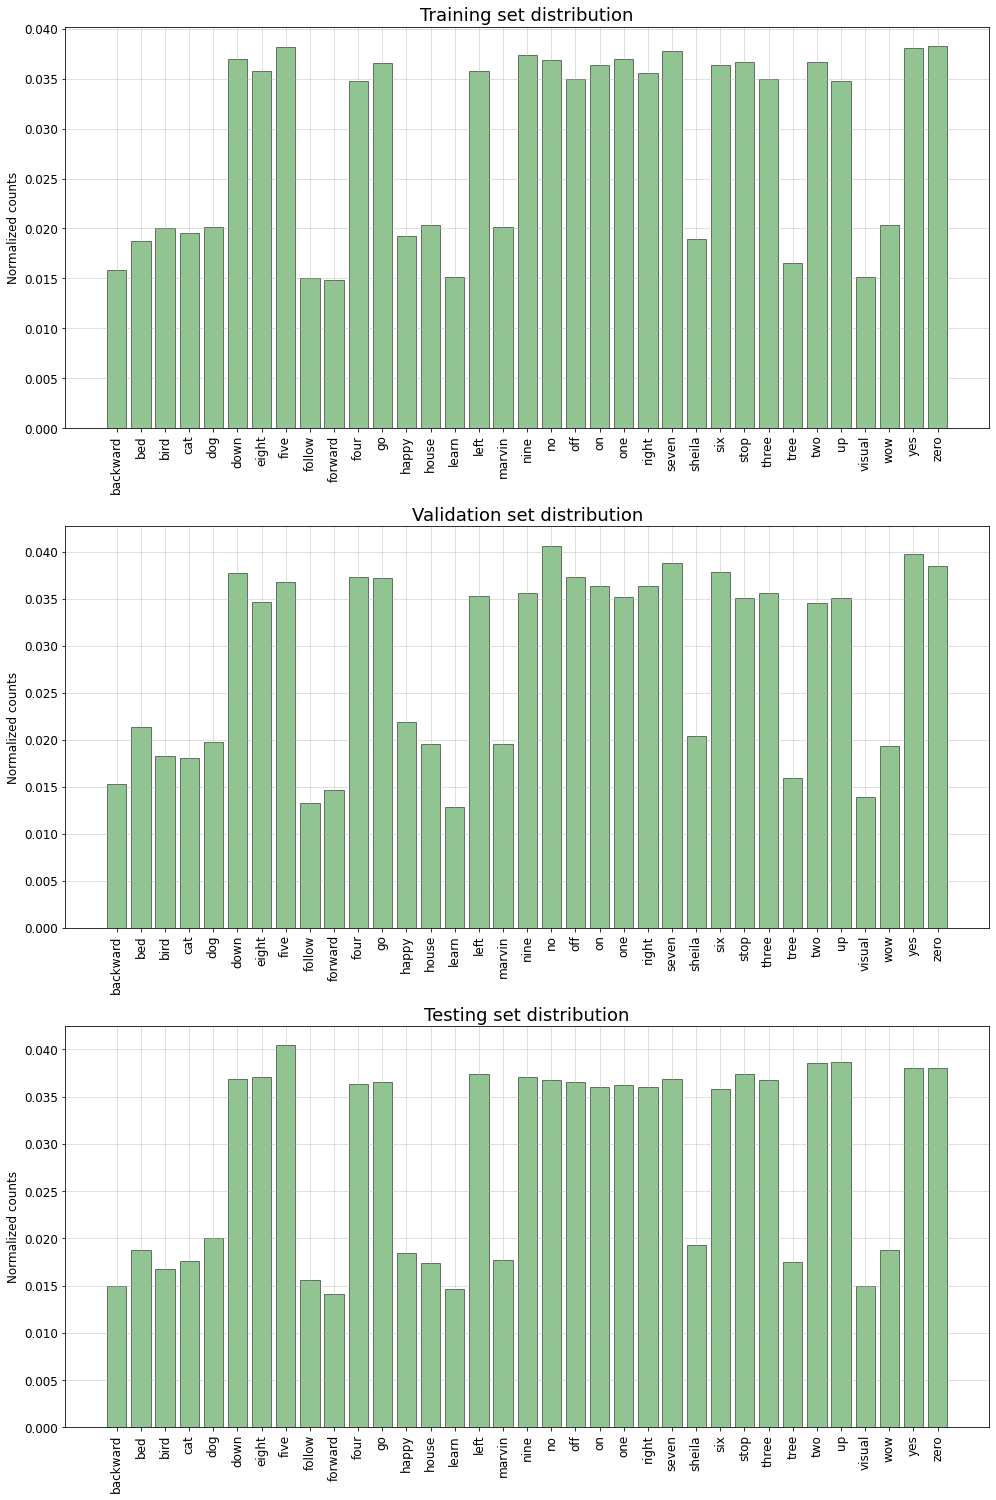

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(14, 21))

plot_utils.hist_class_distribution(reference_df_train, ax[0], commands)
plot_utils.hist_class_distribution(reference_df_val, ax[1], commands)
plot_utils.hist_class_distribution(reference_df_test, ax[2], commands)

for i in range(3):
    ax[i].set_ylabel('Normalized counts')
    ax[i].grid(alpha=0.5)
    ax[i].tick_params(axis='x', labelrotation=90)
    
ax[0].set_title('Training set distribution', fontsize=18)
ax[1].set_title('Validation set distribution', fontsize=18)
ax[2].set_title('Testing set distribution', fontsize=18)

plt.tight_layout()
plt.show()

### 1.5 - Load data
Now we define a function to load the actual audio signals from the files. As data is stored as .wav files, we can load it using the  `wavfile.read` function from the scipy library ([doc here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html)). 

The function takes in input the path of the file to be loaded, that can be obtained from the filename *file_name* (.wav) and the corresponding label *file_label* as:
```python
    file_path = data_path + '/' + file_label + '/' + file_name
```
Then, `wavfile.read(file_path)` returns a tuple of two items: the first is the sampling rate in samples per second, the second is a numpy array with all the data read from the file. As this dataset only contains single channel audio, after getting the data we use the `np.squeeze` function to drop the extra axis.

We show an example for the label _yes_ and one for the label _no_.

In [20]:
print(inspect.getsource(preprocessing_utils.load_data))

def load_data(file_name, file_label, data_path_=data_path):
    
    if isinstance(file_name, bytes):
        file_name   = file_name.decode()
    if isinstance(file_label, bytes):
        file_label  = file_label.decode()
    if isinstance(data_path_, bytes):
        data_path_ = data_path_.decode()

    if not isinstance(file_label, str):
        file_label = class_to_label[file_label]

    file_path = data_path_ + '/' + file_label + '/' + file_name
    _, data  = wavfile.read(file_path)

    return data.squeeze()



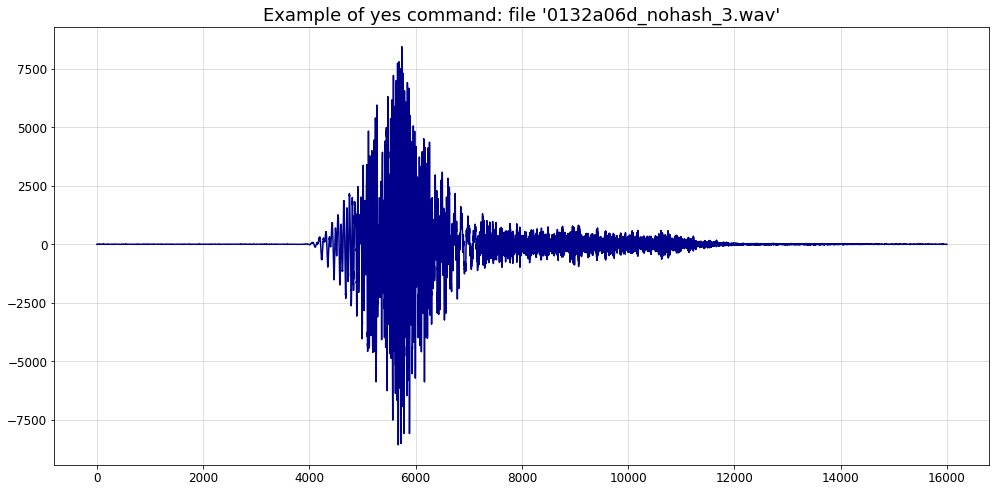

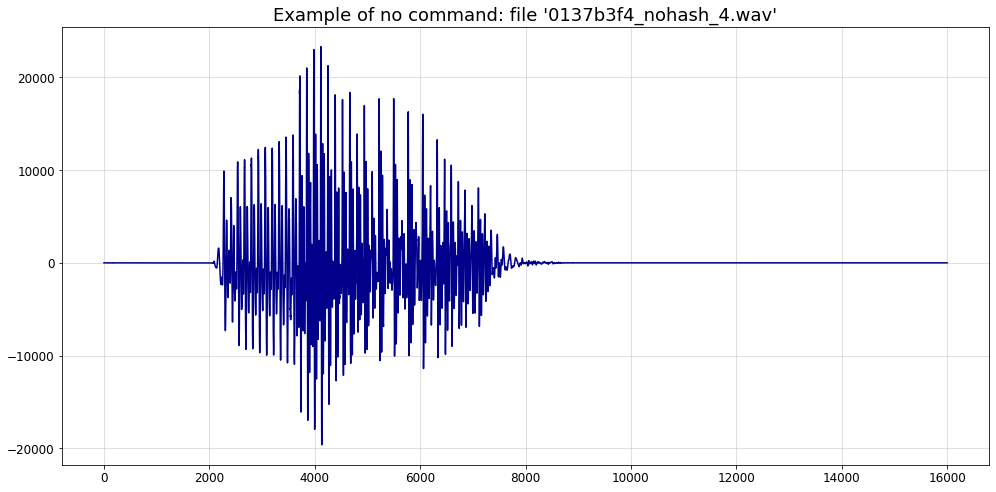

In [21]:
# Examples
# Plot a 'yes' command from training set
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
yes_data = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(yes_data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("Example of yes command: file '{}'".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

# Plot a 'no' command from training set
plot_obj = reference_df_train[reference_df_train.label=='no'].iloc[10]
no_data = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(no_data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("Example of no command: file '{}'".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

### 1.6 - Preprocessing: trimming and padding
Let's print the shape of some training data to see if they are all equal or there are some variations. 

In [22]:
for i in range(50):
    data = preprocessing_utils.load_data(reference_df_train.iloc[i].file, reference_df_train.iloc[i].label)
    print('File: {} - Shape: {}'.format(reference_df_train.iloc[i].file, data.shape))

File: 0165e0e8_nohash_0.wav - Shape: (16000,)
File: 017c4098_nohash_0.wav - Shape: (16000,)
File: 017c4098_nohash_1.wav - Shape: (16000,)
File: 017c4098_nohash_2.wav - Shape: (16000,)
File: 017c4098_nohash_3.wav - Shape: (16000,)
File: 017c4098_nohash_4.wav - Shape: (16000,)
File: 02ade946_nohash_0.wav - Shape: (16000,)
File: 02ade946_nohash_1.wav - Shape: (16000,)
File: 02ade946_nohash_2.wav - Shape: (16000,)
File: 02ade946_nohash_3.wav - Shape: (16000,)
File: 02ade946_nohash_4.wav - Shape: (16000,)
File: 042a8dde_nohash_0.wav - Shape: (16000,)
File: 042a8dde_nohash_1.wav - Shape: (16000,)
File: 042a8dde_nohash_2.wav - Shape: (16000,)
File: 042a8dde_nohash_3.wav - Shape: (16000,)
File: 050170cb_nohash_0.wav - Shape: (16000,)
File: 050170cb_nohash_1.wav - Shape: (16000,)
File: 050170cb_nohash_2.wav - Shape: (16000,)
File: 050170cb_nohash_3.wav - Shape: (16000,)
File: 050170cb_nohash_4.wav - Shape: (16000,)
File: 0585b66d_nohash_0.wav - Shape: (16000,)
File: 0585b66d_nohash_1.wav - Shap

Notice for example that the file 'no/0a396ff2_nohash_0.wav' has shape (9557,), meaning that not all audio files have the same shape. The audio clips are 1 second or less at 16kHz, so we need to pad the short ones to exactly 1 second (and eventually trim the longer ones), so that the samples can be processed by the neural network, that requires a fixed input shape. Most of the samples have 16000 samples (1 second at 16kHz sampling frequency), so let's use this value as our fixed input shape.

In the following function, audio files longer than `output_sequence_length=160000` will be truncated to `output_sequence_length`, while audio signals shorter than this are padded to get the same length. The padding is otained using the `np.pad` function with `mode='mean'` ([doc here](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)). More in detail, we pad half on the left (`int(np.ceil(tot_pads / 2))`) and half on the right (`int(np.floor(tot_pads / 2))`).

When truncating the signal, we decided **not** to randomly select a portion of the signal, as we noticed that in this case we typically don't lose any information by simply cropping it to [0, output_sequence_length-1].


In [23]:
print(inspect.getsource(preprocessing_utils.padding_trimming))

def padding_trimming(data, output_sequence_length=16000):
    
    data_shape = data.shape[0]
    
    # trimming
    if data_shape > output_sequence_length:
        data = data[:output_sequence_length]
    
    # padding
    elif data_shape < output_sequence_length:
        tot_pad    = output_sequence_length - data_shape
        pad_before = int(np.ceil(tot_pad/2))
        pad_after  = int(np.floor(tot_pad/2))
        data       = np.pad(data, pad_width=(pad_before, pad_after), mode='mean')
        
    return data



File: off/f1d36c53_nohash_0.wav - Shape: (16000,)


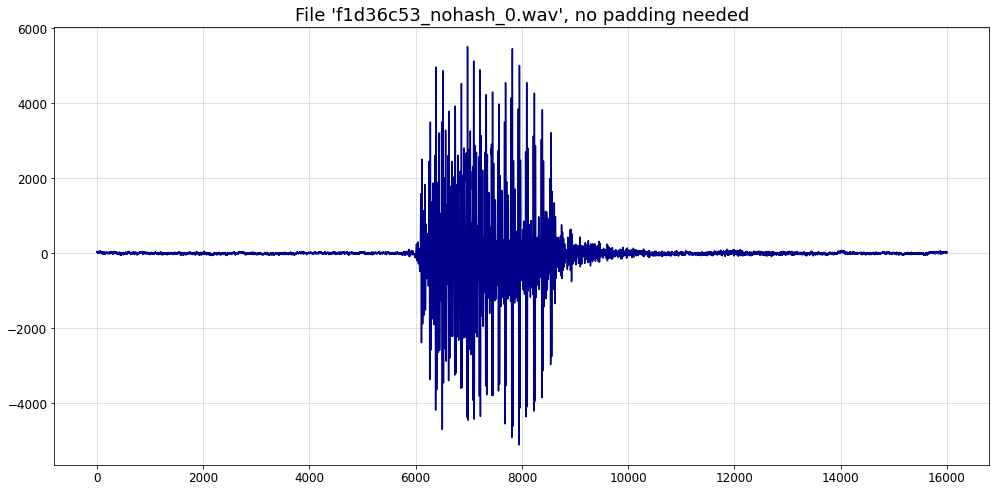

File: no/0a396ff2_nohash_0.wav - Shape: (9557,)

After padding:
File: no/0a396ff2_nohash_0.wav - Shape: (16000,)


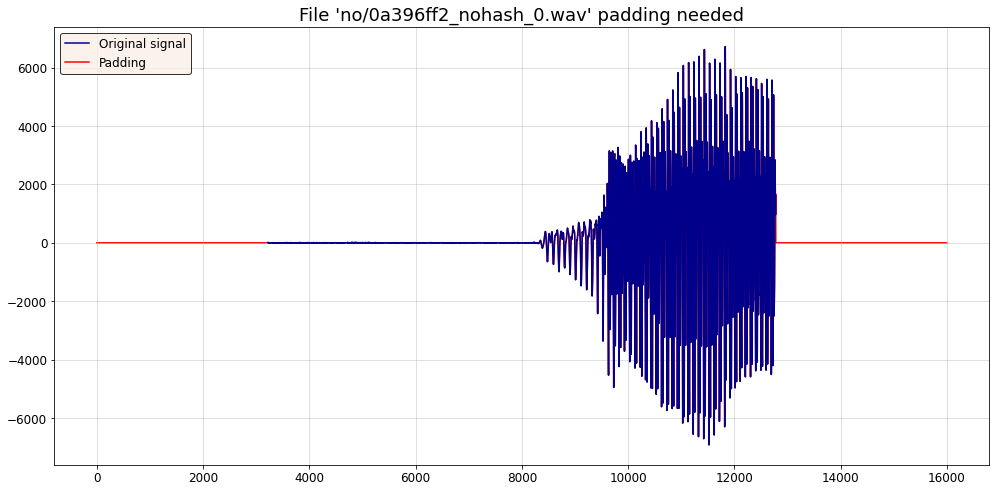

In [24]:
# let's test it on a audio file with correct length
plot_obj = reference_df_train[(reference_df_train.file=='f1d36c53_nohash_0.wav') & (reference_df_train.label=='off')].iloc[0]
data = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)
print('File: %s/{} - Shape: {}'.format(plot_obj.file, data.shape) %(plot_obj.label))

data = preprocessing_utils.padding_trimming(data)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("File '{}', no padding needed".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

# let's test it on 0a396ff2_nohash_0.wav, as we know it needs padding
plot_obj = reference_df_train[(reference_df_train.file=='0a396ff2_nohash_0.wav') & (reference_df_train.label=='no')].iloc[0]
data = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)
print('File: %s/{} - Shape: {}'.format(plot_obj.file, data.shape)  %(plot_obj.label))

data_new = preprocessing_utils.padding_trimming(data)
print('\nAfter padding:')
print('File: %s/{} - Shape: {}'.format(plot_obj.file, data_new.shape)  %(plot_obj.label))

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(np.arange((16000-data.shape[0])//2, (16000-data.shape[0])//2+data.shape[0]), data, color='darkblue', label='Original signal', zorder=2)
ax.plot(data_new, color='red', label='Padding', zorder=1)
ax.grid(alpha=0.5)
ax.set_title("File '%s/{}' padding needed".format(plot_obj.file) %(plot_obj.label), fontsize=18)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='upper left')

plt.tight_layout()
plt.show()

![](example1.png)
![](example2.png)

### 1.7 - Background Noise 
To help train machine learning models to cope with noisy environments, it can be helpful to mix in realistic background audio. The `_background_noise_` folder contains a set of longer audio clips that are either recordings or mathematical simulations of noise. They were all either collected personally by Pete Warden in July 2017, or generated in the case of the pink and white noise. For more details, see the `_background_noise_/README.md`.

We define a function to mix one of these background audio signals into an input audio clip. With `select_noise` it is possible to select which of the available background audio clips to use. In particular, the following match is applied:

$1 \longrightarrow $ doing_the_dishes.wav <br>
$2 \longrightarrow $ dude_miaowing.wav <br>
$3 \longrightarrow $ exercise_bike.wav <br>
$4 \longrightarrow $ pink_noise.wav <br>
$5 \longrightarrow $ running_tap.wav <br>
$6 \longrightarrow $ white_noise.wav 

If `select_noise=None` (default value), then the background noise is randomly chosen between the available ones. Moreover, as these clips  still have a 16kHz sample rate but are longer than 1 second, we randomly select a portion of them to match the size of the input.


In [25]:
print(inspect.getsource(preprocessing_utils.background_noise))

def background_noise(data, noise_dict, select_noise=None, noise_reduction=0.5, *args):
    '''
    data: input audio signal, already loaded and preprocessed, it must be a numpy array 
    select_noise: decide what kind of noise to add to the input signal, by default a random choice 
    noise_reduction: set it to a value between 0 and 1 to reduce the amount of noise, by default 0.8
    '''
    
    # noise selection
    if (select_noise is None) or (select_noise == -1):
        select_noise = np.random.choice(np.arange(1, 7)) # random selection
    noise_data = args[select_noise-1] if (noise_dict == -1) else noise_dict[str(select_noise)]
    
    # random cropping
    target_size = data.shape[0]
    noise_size  = noise_data.shape[0]
    from_       = np.random.randint(0, int(noise_size-target_size))
    to_         = from_ + target_size
    noise_data  = noise_data[from_:to_]
    
    # add noise to input audio
    data_with_noise = data + (1-noise_reduction)*noise_data
    
    return

/content/preprocessing_utils.py:70: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


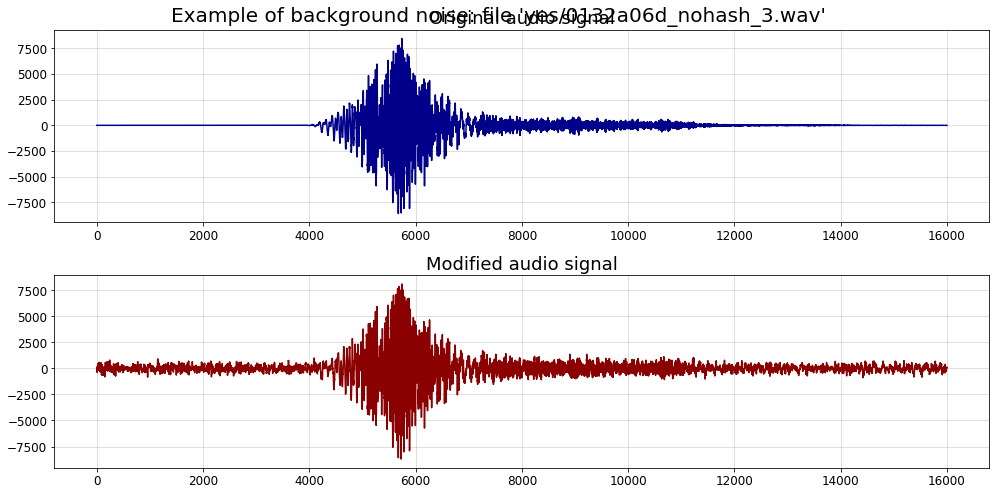

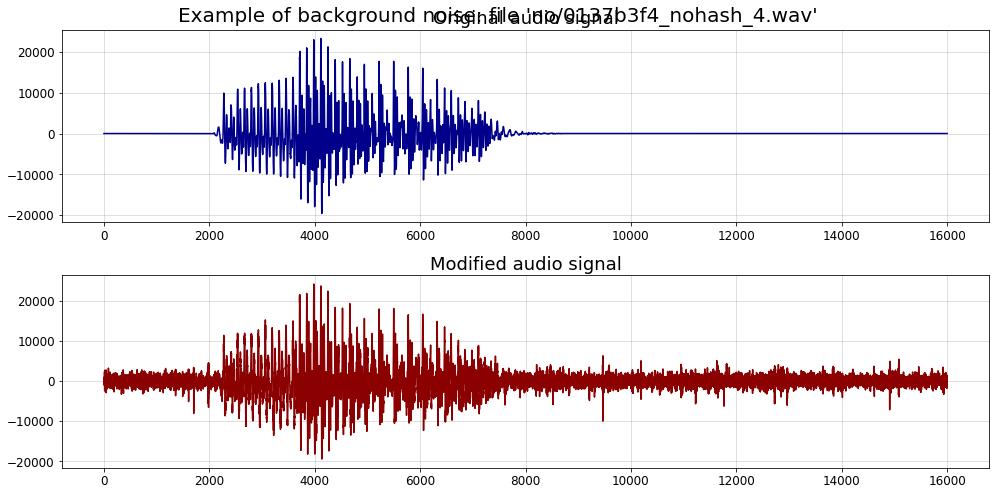

In [26]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = preprocessing_utils.load_data('doing_the_dishes.wav', noise_path)
noise_2 = preprocessing_utils.load_data('dude_miaowing.wav', noise_path)
noise_3 = preprocessing_utils.load_data('exercise_bike.wav', noise_path)
noise_4 = preprocessing_utils.load_data('pink_noise.wav', noise_path)
noise_5 = preprocessing_utils.load_data('running_tap.wav', noise_path)
noise_6 = preprocessing_utils.load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}
        
# Let's test it on the same examples we used before
np.random.seed(22)

# 'yes' command from training set, with 'doing_the_dishes.wav' background noise
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
yes_data = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)

yes_data_wn = preprocessing_utils.background_noise(yes_data, noise_dict, select_noise=1)

fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].plot(yes_data, color='darkblue')
ax[1].plot(yes_data_wn, color='darkred')

for i in range(2):
    ax[i].grid(alpha=0.5)

ax[0].set_title('Original audio signal', fontsize=18)
ax[1].set_title('Modified audio signal', fontsize=18)
fig.suptitle("Example of background noise: file 'yes/{}'".format(plot_obj.file), fontsize=20)

plt.tight_layout()
plt.show()

# 'no' command from training set, with random background noise
plot_obj = reference_df_train[reference_df_train.label=='no'].iloc[10]
no_data = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)

no_data_wn = preprocessing_utils.background_noise(no_data, noise_dict)

fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].plot(no_data, color='darkblue')
ax[1].plot(no_data_wn, color='darkred')

for i in range(2):
    ax[i].grid(alpha=0.5)

ax[0].set_title('Original audio signal', fontsize=18)
ax[1].set_title('Modified audio signal', fontsize=18)
fig.suptitle("Example of background noise: file 'no/{}'".format(plot_obj.file), fontsize=20)

plt.tight_layout()
plt.show()

Let's play these audio signals.  

In [27]:
Audio(yes_data, rate=16000)

In [28]:
Audio(yes_data_wn, rate=16000)

In [29]:
Audio(no_data, rate=16000)

In [30]:
Audio(no_data_wn, rate=16000)

### 1.8 - Extract features

#### 1.8.1 - Spectrogram

The waveforms in the dataset are represented in the time domain. Next, we'll transform the waveforms from the time-domain signals into the frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. We will feed the spectrogram images into our neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor on which standard convolutions can be runned.

Let's create a utility function for converting waveforms to spectrograms:

- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, we'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [31]:
print(inspect.getsource(preprocessing_utils.get_spectrogram))

def get_spectrogram(
                    signal,                               # audio signal from which to compute features (N*1 array)
                    samplerate = 16000,                   # samplerate of the signal we are working with
                    winlen     = 25,                      # length of the analysis window (milliseconds)
                    winstep    = 10,                      # step between successive windows (milliseconds)
                    nfft       = 512,                     # FFT size
                    winfunc    = tf.signal.hamming_window # analysis window to apply to each frame
                    ):

    # Convert the waveform to a spectrogram via a STFT
    spectrogram = tf.signal.stft(
                                signal.astype(float),
                                int(samplerate*winlen/1000),
                                int(samplerate*winstep/1000),
                                nfft,
                                winfunc
          

Feature vector shape: (257, 98)


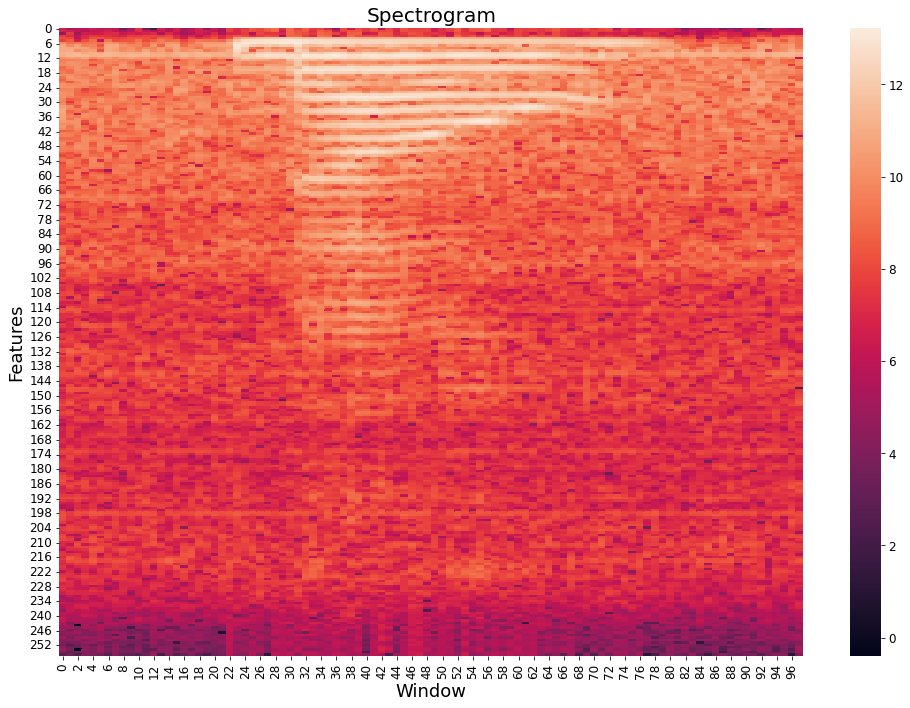

In [32]:
plot_obj = reference_df_train.sample().squeeze()
signal = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)

spectrogram = preprocessing_utils.get_spectrogram(signal)
print("Feature vector shape:", spectrogram.shape)
plot_utils.plot_features(spectrogram, title='Spectrogram')

#### 1.8.2 - Log Mel-filterbank energy features

In [33]:
print(inspect.getsource(preprocessing_utils.get_logfbank))

def get_logfbank(
                signal,             # audio signal from which to compute features (N*1 array)
                samplerate = 16000, # samplerate of the signal we are working with
                winlen     = 25,    # length of the analysis window (milliseconds)
                winstep    = 10,    # step between successive windows (milliseconds)
                nfilt      = 40,    # number of filters in the filterbank
                nfft       = 512,   # FFT size
                lowfreq    = 300,   # lowest band edge of mel filters (Hz)
                highfreq   = None,  # highest band edge of mel filters (Hz)
                ):

    if highfreq is None:
        highfreq = samplerate / 2

    # Extract log Mel-filterbank energy features
    logfbank_feat = logfbank(
                            signal,
                            samplerate,
                            winlen/1000,
                            winstep/1000,
                            nfilt,
            

Let's sample a random audio signal from `reference_df_train` and extract log Mel-filterbank energy features from it.

Feature vector shape: (40, 99)


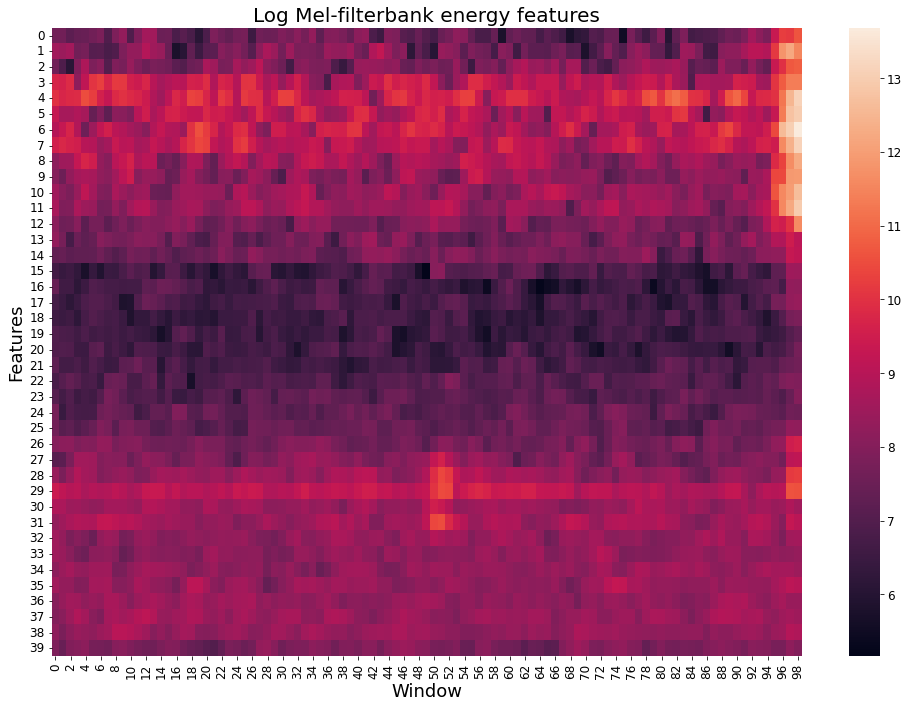

In [34]:
plot_obj = reference_df_train.sample().squeeze()
signal = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)

logfbank_features = preprocessing_utils.get_logfbank(signal)
print("Feature vector shape:", logfbank_features.shape)
plot_utils.plot_features(logfbank_features, title='Log Mel-filterbank energy features')

#### 1.8.3 - MFCC features
Reference: [A Step-by-Step Guide to Speech Recognition and Audio Signal Processing in Python | Towards Data Science](https://towardsdatascience.com/a-step-by-step-guide-to-speech-recognition-and-audio-signal-processing-in-python-136e37236c24) 

MFCC is a technique designed to extract features from an audio signal. It uses the Mel scale to divide the audio signal’s frequency bands and then extracts coefficients from each individual frequency band, thus, creating a separation between frequencies. MFCC uses the Discrete Cosine Transform (DCT) to perform this operation. The Mel scale is established on the human perception of sound, i.e., how the human brain process audio signals and differentiates between the varied frequencies.

Unless written otherwise, we compute the features framing the signal into 25ms time windows with a 10ms frame shift and using 40 Mel filterbanks.

In [35]:
print(inspect.getsource(preprocessing_utils.get_mfcc))

def get_mfcc(
            signal,                    # audio signal from which to compute features (N*1 array)
            delta_order  = 2,          # maximum order of the Delta features
            delta_window = 1,          # window size for the Delta features
            samplerate   = 16000,      # samplerate of the signal we are working with
            winlen       = 25,         # length of the analysis window (milliseconds)
            winstep      = 10,         # step between successive windows (milliseconds)
            numcep       = 13,         # number of cepstrum to return
            nfilt        = 40,         # number of filters in the filterbank
            nfft         = 512,        # FFT size
            lowfreq      = 300,        # lowest band edge of mel filters (Hz)
            highfreq     = None,       # highest band edge of mel filters (Hz)
            appendEnergy = True,       # if this is true, the zeroth cepstral coefficient is replaced with the log of the 

Let's sample a random audio signal from `reference_df_train` and extract MFCC features from it.

Feature vector shape: (39, 99)


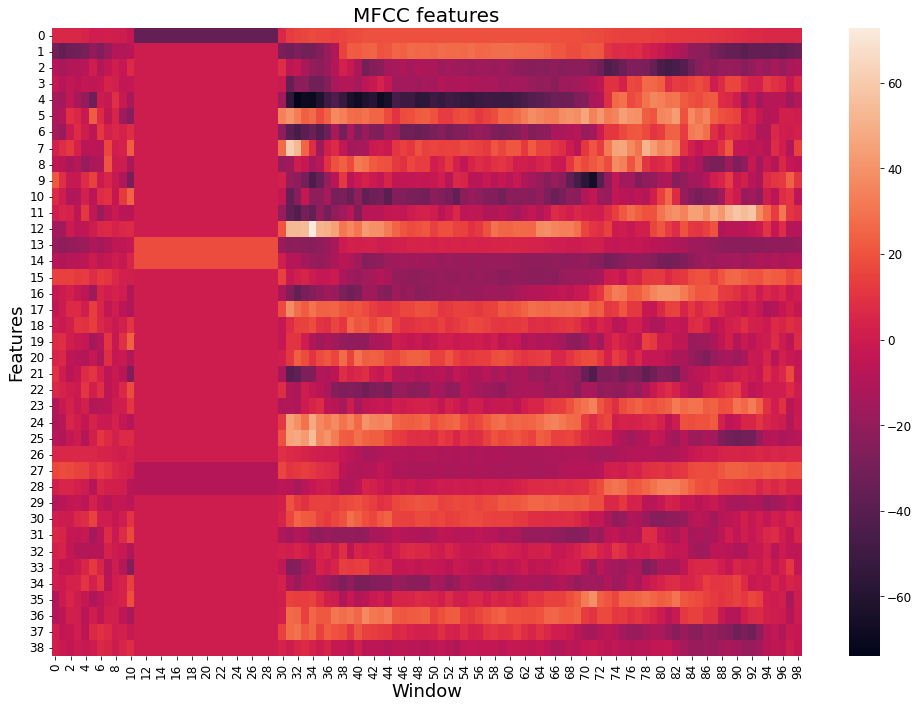

In [36]:
plot_obj = reference_df_train.sample().squeeze()
signal = preprocessing_utils.load_data(plot_obj.file, plot_obj.label)

mfcc_features = preprocessing_utils.get_mfcc(signal)
print("Feature vector shape:", mfcc_features.shape)
plot_utils.plot_features(mfcc_features, title='MFCC features')

### 1.9 - Loading and preprocessing function
We define a function that helps us loading and preprocessing data. This function performs only the first part of the preprocessing, in detail loading and padding/trimming. Data augmentation techniques and the feature extraction are then applied in a second step in our training pipeline, as the randomization must be applied after caching.  

In [37]:
print(inspect.getsource(preprocessing_utils.load_and_preprocess_data))

def load_and_preprocess_data(file_name, file_label, data_path_=data_path):

    # load data
    data = load_data(file_name, file_label, data_path_=data_path_)
    
    # padding/trimming
    data = padding_trimming(data)
        
    # TensorFlow takes as input 32-bit floating point data
    return data.astype(np.float32)



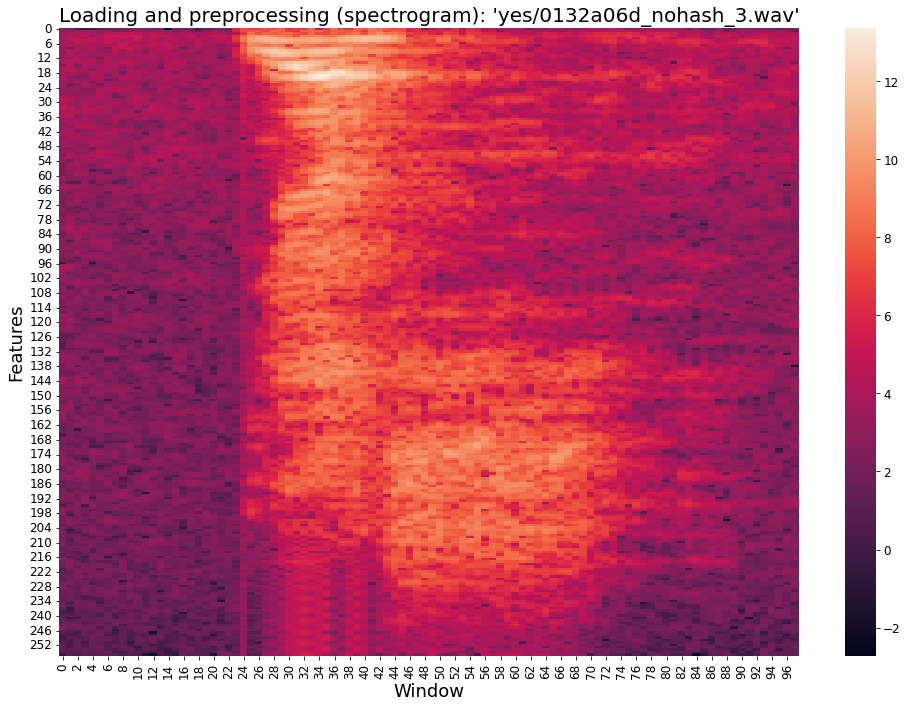

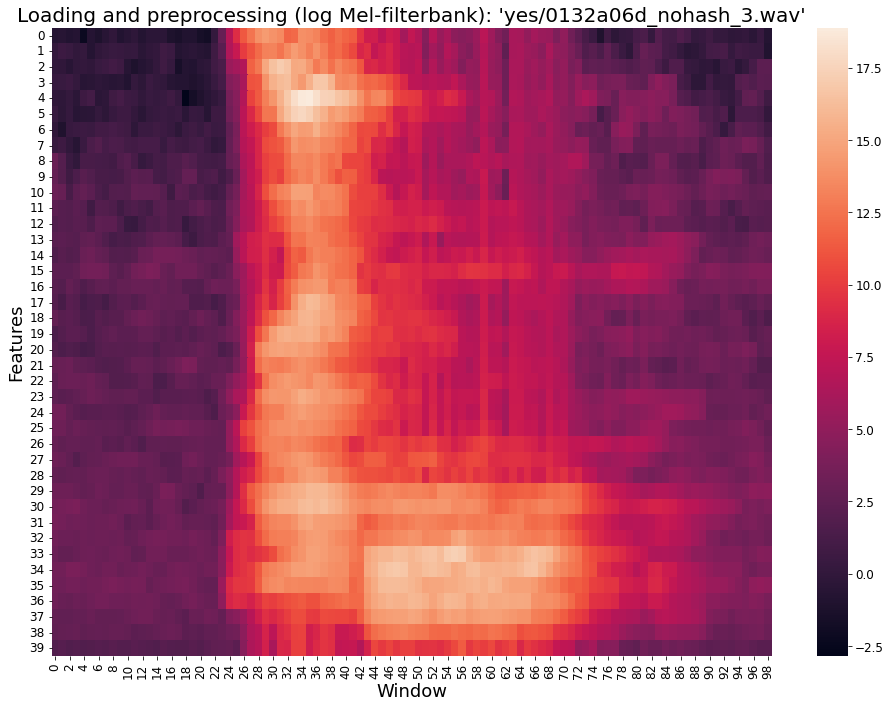

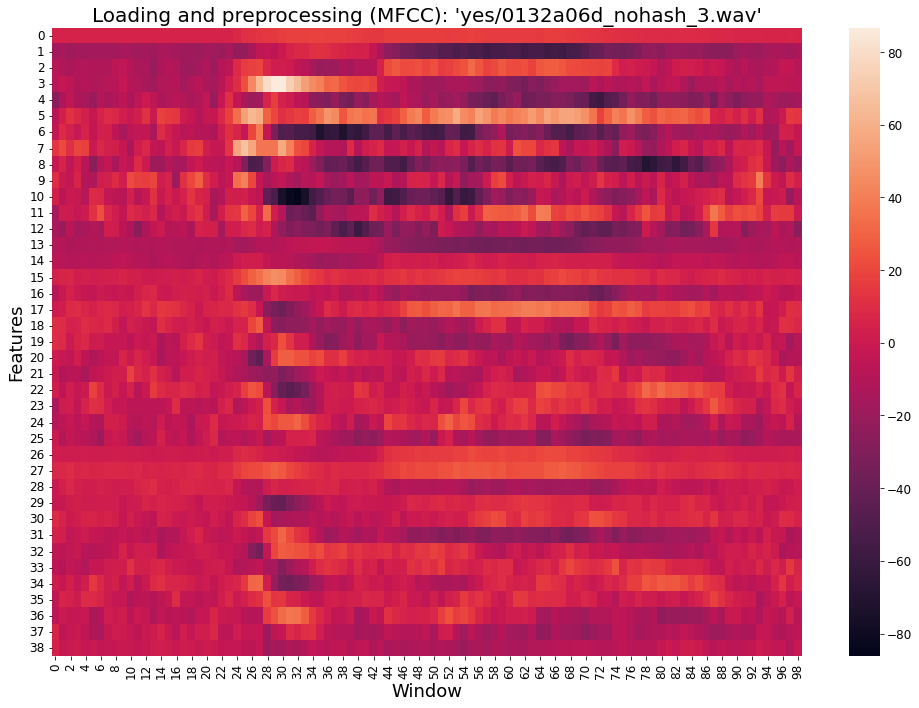

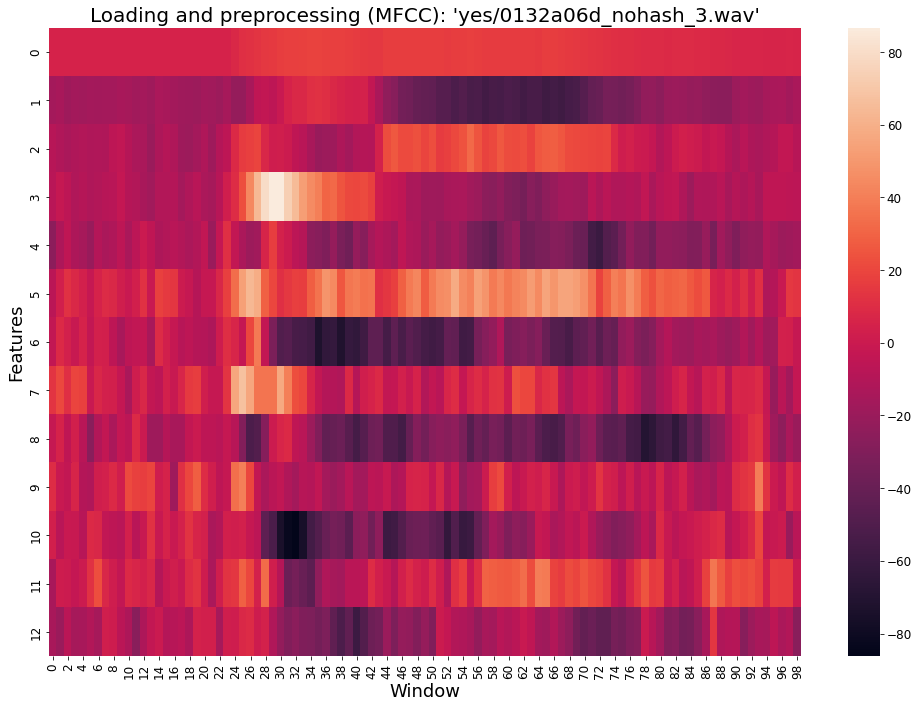

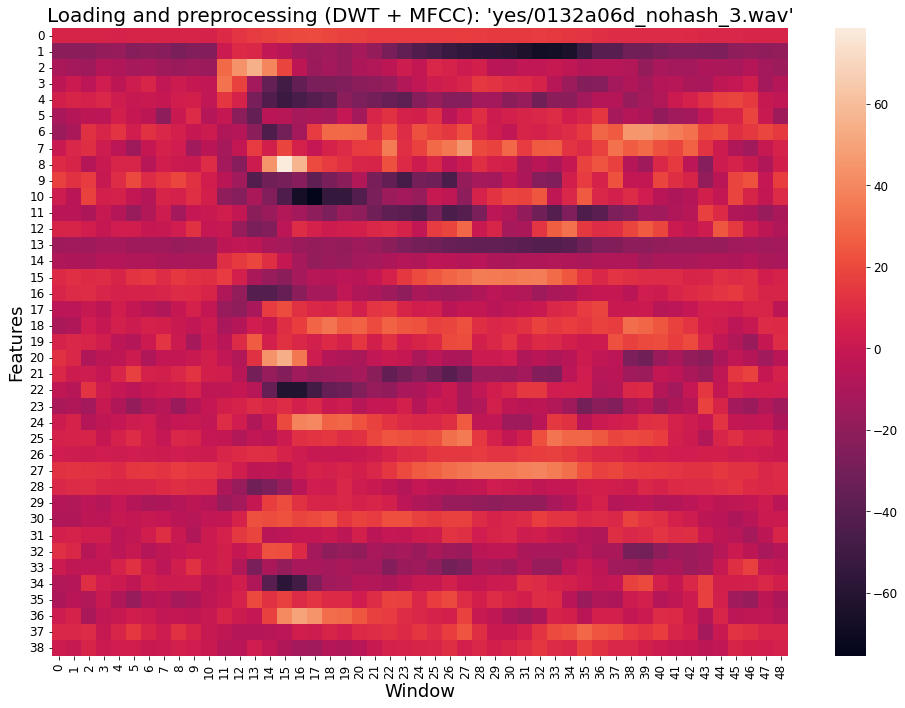

In [38]:
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
plot_preprocess = preprocessing_utils.load_and_preprocess_data(plot_obj.file, plot_obj.label)

# Example using spectrogram
plot_data = preprocessing_utils.get_spectrogram(plot_preprocess)
plot_utils.plot_features(plot_data, title="Loading and preprocessing (spectrogram): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# Example using log Mel-filterbank energy features
plot_data = preprocessing_utils.get_logfbank(plot_preprocess)
plot_utils.plot_features(plot_data, title="Loading and preprocessing (log Mel-filterbank): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# Example using MFCC features, delta_order=2
plot_data = preprocessing_utils.get_mfcc(plot_preprocess)
plot_utils.plot_features(plot_data, title="Loading and preprocessing (MFCC): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# Example using MFCC features, delta_order=0
plot_data = preprocessing_utils.get_mfcc(plot_preprocess, delta_order=0)
plot_utils.plot_features(plot_data, title="Loading and preprocessing (MFCC): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# Example using Discrete Wavelet Transform + MFCC features
plot_data = preprocessing_utils.get_mfcc(preprocessing_utils.get_dwt(plot_preprocess))
plot_utils.plot_features(plot_data, title="Loading and preprocessing (DWT + MFCC): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

## 2 - PCA and K-Means
### 2.1 - Import a part of the dataset 

In [ ]:
def load_and_preprocess_noisedict_passed(file_name, file_label, data_path_=data_path, apply_background_noise=False):
    data_ = preprocessing_utils.load_and_preprocess_data(file_name, file_label, data_path_=data_path_)

    if apply_background_noise:
        data_ = preprocessing_utils.background_noise(data_, noise_dict=noise_dict)

    return data_.astype(np.float32)

def make_dataset(df, data_path_=data_path, apply_background_noise=False):
    # Convert DataFrame to lists
    file_names = df['file'].tolist()
    file_labels = df['class'].tolist()

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, file_labels))

    # Map the "load_and_preprocess_noisedict_passed" function
    def numpy_func(file_name, file_label):
        return tf.numpy_function(load_and_preprocess_noisedict_passed, inp=[file_name, file_label, data_path_, apply_background_noise], Tout=tf.float32)
    dataset = dataset.map(numpy_func, num_parallel_calls=os.cpu_count())

    return dataset

In [ ]:
# only 10500 samples (300 x class)
sample_per_class = 300
reference_df_pca = reference_df_train[reference_df_train['class']==0].sample(n=sample_per_class, replace=False)

for i in np.arange(1, 35):
  reference_df_pca = reference_df_pca.append(reference_df_train[reference_df_train['class']==i].sample(n=sample_per_class, replace=False))

print('Number of samples:', len(reference_df_pca))

apply_bn = True
features_to_extract = 0
batch_size = 32

train_dataset = make_dataset(
    reference_df_pca, 
    apply_background_noise=apply_bn,
  )

train_dataset = np.array(list(train_dataset.as_numpy_iterator()))

Number of samples: 10500


In [ ]:
pca = PCA(svd_solver='auto')
pca.fit(train_dataset)

PCA()

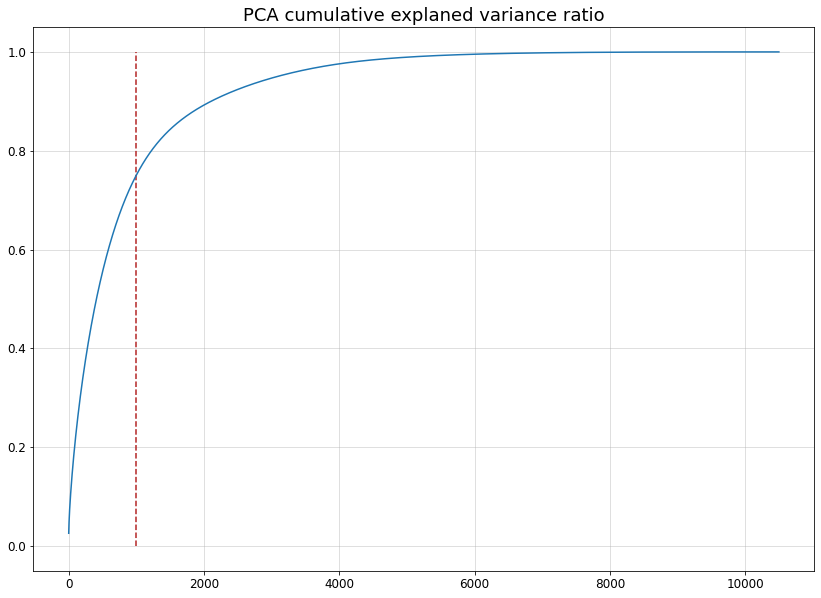

In [ ]:
_, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum())
ax.vlines(x=1000, ymin=0, ymax=1, linestyle='dashed', color='firebrick')
ax.grid(alpha=0.5)
ax.set_title('PCA cumulative explaned variance ratio', fontsize=18)
plt.show()

In [ ]:
pca = PCA(n_components=1000, svd_solver='auto')
pca.fit(train_dataset)
scores_pca = pca.transform(train_dataset)
labels_pca = np.array(reference_df_pca['class'])

# _, ax = plt.subplots(figsize=(14,10))
# for i in range(35):
#    ax.scatter(scores_pca[labels_pca == i , 0] , scores_pca[labels_pca == i , 1] , label = i)
# 
# ax.set_ylim(top=0.5*10**6)

In [ ]:
kmeans = KMeans(n_clusters=35, init="k-means++")
label_km = kmeans.fit_predict(scores_pca)

Number of signals in cluster 0: 2
Number of signals in cluster 1: 9441
Number of signals in cluster 2: 1
Number of signals in cluster 3: 1
Number of signals in cluster 4: 1
Number of signals in cluster 5: 1
Number of signals in cluster 6: 1
Number of signals in cluster 7: 1
Number of signals in cluster 8: 1
Number of signals in cluster 9: 1
Number of signals in cluster 10: 1
Number of signals in cluster 11: 1
Number of signals in cluster 12: 1
Number of signals in cluster 13: 1
Number of signals in cluster 14: 1
Number of signals in cluster 15: 18
Number of signals in cluster 16: 1
Number of signals in cluster 17: 1
Number of signals in cluster 18: 1
Number of signals in cluster 19: 1
Number of signals in cluster 20: 1
Number of signals in cluster 21: 1
Number of signals in cluster 22: 1
Number of signals in cluster 23: 1
Number of signals in cluster 24: 1
Number of signals in cluster 25: 1
Number of signals in cluster 26: 1
Number of signals in cluster 27: 1
Number of signals in clust

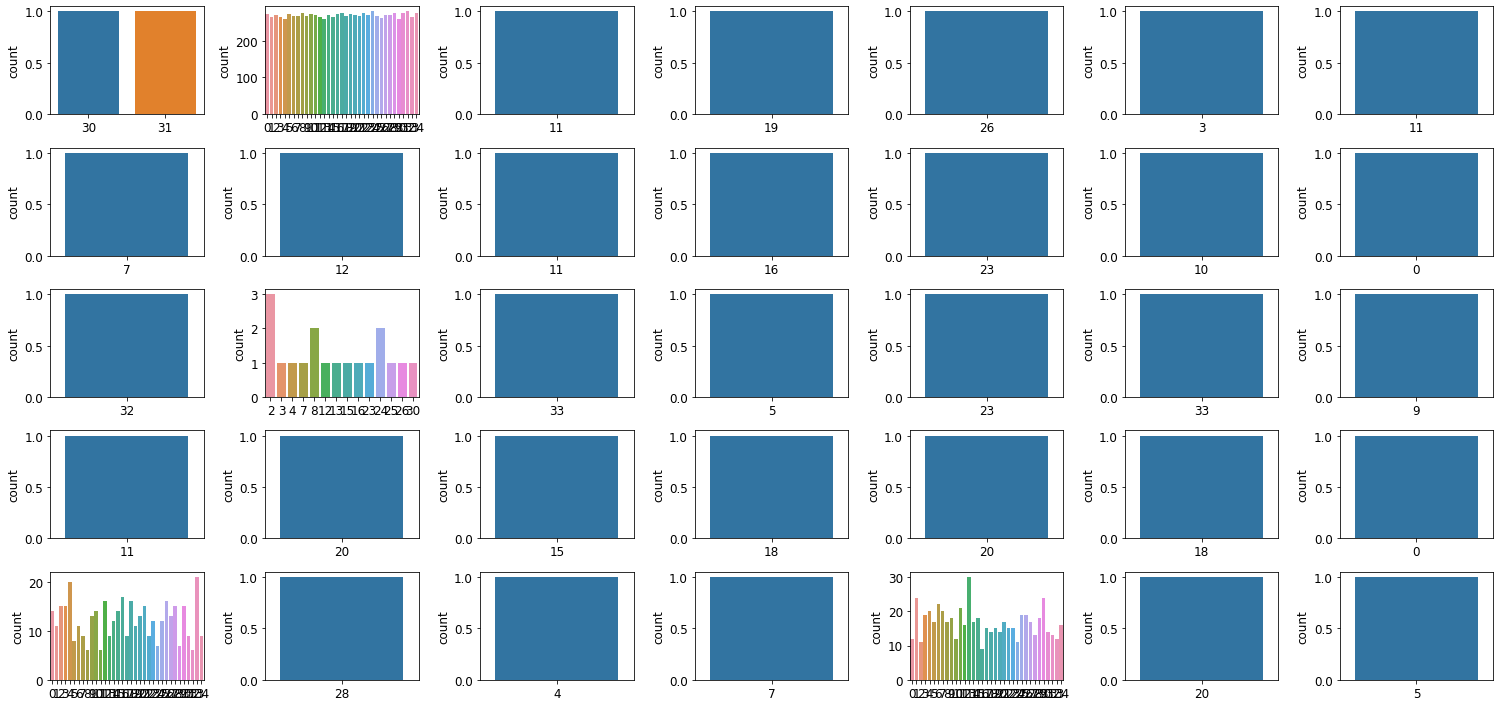

In [ ]:
# plot distribution of data in the clusters
plt.rcParams.update({'figure.max_open_warning': 40})

lab_sel = np.arange(35)
_, ax = plt.subplots(5, 7, figsize=(21, 10))

# plot
for i, lab in enumerate(lab_sel):
  print('Number of signals in cluster %i: %i' %(lab, sum(label_km==lab)))
  sns.countplot(x=labels_pca[label_km==lab], ax=ax[i//7, i%7])

print('\n')
plt.tight_layout()
plt.show()

# References
**[Sainath15]** <br>
 Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
 Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
 James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.
